# Diffusion models

Diffusion models are another class of generative deep learning models, that basically learn to generate samples from noise by gradually removing the correct amount of noise. Let's implement the forward pass, and you will implement the full model (the backward pass and the training) in your homework.

In [1]:
import os
# For interactive plotting:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass
try:
    %matplotlib widget
except:
    os.system('pip install ipympl -qq')
    %matplotlib widget

import torch
from torchvision import datasets
from torchvision.transforms import v2

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'
print(f'Device is {Device}')

Device is cuda


In [2]:
train_dataset = datasets.MNIST(
    root = 'MNIST',
    train = True,
    download = True,
    # transform the data to torch.Tensor and scale it to [0, 1]
    transform = v2.Compose([
        # convert to tensor and scale to [0, 1]
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ])
    )

## Forward diffusion ($q$)

We denote an elementwise normal distribution with $N(\mathbf{\mu}, \mathbf{\sigma}^2)$ where $\mathbf{\mu}$ is the mean tensor and $\mathbf{\sigma}^2$ is the varianve tensor ($\mathbf{\sigma}$ is the standard deviation). Following this notation, we can represent each forward diffusion step as the following:
$$
q(\mathbf{x}_t|\mathbf{x}_{t-1}) = N(\sqrt{1-\beta_t}\mathbf{x}_t, \beta_t\mathbf{1})
$$
Therefore, the sampling would be:
$$
\mathbf{x}_t = (\sqrt{1-\beta_t})\mathbf{x}_{t-1} + (\sqrt{\beta_t})\epsilon
$$
$$
\epsilon \sim N(\mathbf{0}, \mathbf{1})
$$

The good news is, there is a closed-form formula to obtain a noisy $\mathbf{x}_t$ directly from $\mathbf{x}_0$, and it is as follows:
$$
q(\mathbf{x}_t|\mathbf{x}_0) = N\big(\sqrt{\bar{\alpha}_t}\mathbf{x}_0, (1-\bar{\alpha}_t)\mathbf{1}\big)
$$
Therefore, the sampling would be:
$$
\mathbf{x}_t = (\sqrt{\bar{\alpha}_t})\mathbf{x}_0 + (\sqrt{1-\bar{\alpha}_t})\epsilon
$$
Where 
$$
\alpha_t = 1 - \beta_t
$$
$$
\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s
$$
$$
\epsilon \sim N(\mathbf{0}, \mathbf{1})
$$

Remember that typically it is assumed that the elements in $\epsilon$ are independent, so sometimes you may see the variance including an $\mathbf{I}$ in the standard multivariate distribution notation. However, since the elements are independent, we can implement things elementwise. One thing to remember is that the noise should be of the same shape and device as the data. You can simply use `randn_like` for that.


The design of the schedule of $\beta_t$ or $\bar{\alpha_t}$ is a hyperparameter. In [the DDPM paper](https://arxiv.org/pdf/2006.11239), they explore constant, linear, and quadratic schedule. In [this paper](https://arxiv.org/pdf/2102.09672) from OpenAI, they suggest a cosine schedule. Let's compare them.

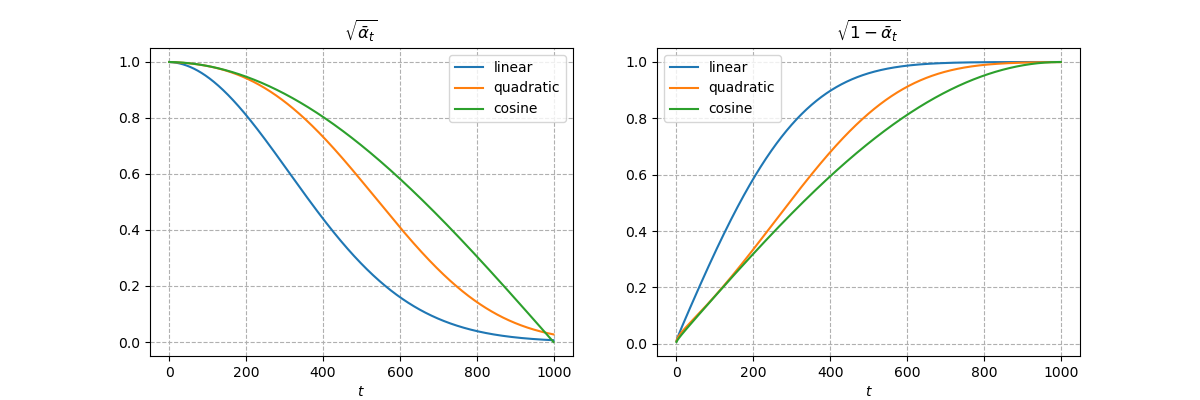

In [3]:
# ==== forward diffusion hyperparameters ====
b_0 = 1e-4
b_T = 2e-2
T = 1000
# ===========================================

# linear
beta_lin = torch.linspace(b_0, b_T, T)
alpha_lin = 1 - beta_lin
alpha_bar_lin = torch.cumprod(alpha_lin, dim=0)

# quadratic
beta_quad = torch.linspace(b_0**0.5, b_T**0.5, T)**2
alpha_quad = 1 - beta_quad
alpha_bar_quad = torch.cumprod(alpha_quad, dim=0)

# cosine
s = 0.008
f = lambda t: torch.cos((t/T+s)/(1+s) * torch.pi/2) ** 2
alpha_bar_cos = f(torch.arange(T+1))/f(torch.tensor(0.))
beta_cos = 1 - alpha_bar_cos[1:]/alpha_bar_cos[:-1]
alpha_bar_cos = alpha_bar_cos[1:] # discarding alpha_bar[0]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ax1 for mean_coeff
ax1.plot(alpha_bar_lin**0.5, label='linear')
ax1.plot(alpha_bar_quad**0.5, label='quadratic')
ax1.plot(alpha_bar_cos**0.5, label='cosine')
ax1.set_title(r'$\sqrt{\bar{\alpha}_t}$')
ax1.set_xlabel(r'$t$')
ax1.legend()
ax1.grid(linestyle='--')

# ax2 for noise_std
ax2.plot((1-alpha_bar_lin)**0.5, label='linear')
ax2.plot((1-alpha_bar_quad)**0.5, label='quadratic')
ax2.plot((1-alpha_bar_cos)**0.5, label='cosine')
ax2.set_title(r'$\sqrt{1-\bar{\alpha}_t}$')
ax2.set_xlabel(r'$t$')
ax2.legend()
ax2.grid(linestyle='--')

plt.show()

interactive(children=(IntSlider(value=0, description='t:', layout=Layout(width='50%'), max=1000), Output()), _…

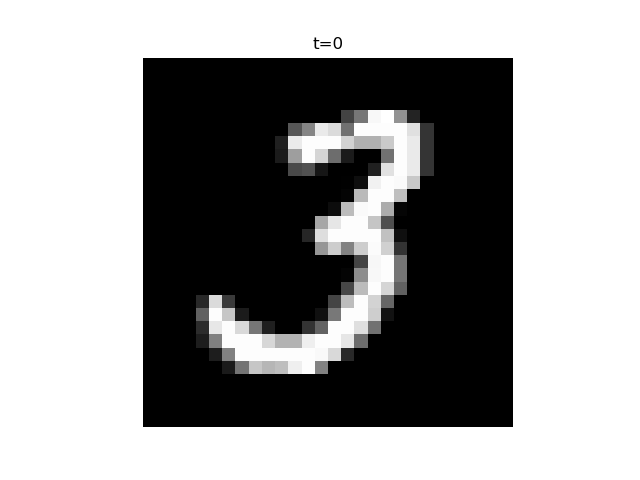

In [4]:
# Take a sample from the dataset and look at the noised images through the diffusion process

# Let's use the quadratic schedule
mean_coeff_schedule = alpha_bar_quad ** 0.5
noise_std_schedule = (1 - alpha_bar_quad) ** 0.5

x0 = train_dataset[321][0]
noisy = [x0]

for t in range(T):
    noisy.append(
        mean_coeff_schedule[t] * x0 + noise_std_schedule[t] * torch.randn_like(x0)
    )

# create a widget to visualize the noised images
%matplotlib widget
import ipywidgets as widgets

fig, ax = plt.subplots()

t_widget = widgets.IntSlider(
    value = 0,
    min = 0,
    max = T,
    step = 1,
    description = 't:',
    continuous_update = True,
    layout = widgets.Layout(width='50%')
    )

def update(t: int):
    ax.clear()
    ax.imshow(noisy[t].cpu().numpy().squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f't={t}')
    fig.canvas.draw()
    fig.canvas.flush_events()

widgets.interactive(update, t=t_widget)


You will implement the full pipeline for training and data generation in the assignment!